In [1]:
import pandas as pd
import nltk
from nltk.stem import PorterStemmer
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
def run_tests(clf, name, X_train, y_train, X_test, y_test):
    """
        returns the test auroc
    """
    t0 = time.time()
    trained = clf.fit(X_train, y_train)
    t1 = time.time()
    pred1 = trained.predict(X_test)
    t2 = time.time()
    pa1 = trained.predict_proba(X_test)[:, 1]

    pred2 = trained.predict(X_train)
    pa2 = trained.predict_proba(X_train)[:, 1]

    print(pa1.shape, pa2.shape)

    # pred3 = trained.predict(X_val)
    # pa3 = trained.predict_proba(X_test)[:, 1]

    met1 = get_metrics(name + ' X_test', y_test, pred1, pa1)
    met2 = get_metrics(name + ' X_train', y_train, pred2, pa2)
    # met3 = get_metrics(name + ' X_val', y_val, pred3, pa3)

    print(f"({name}) Time to train", t1 - t0)
    print(f"({name}) Avg time to classify", (t2 - t1) / X_test.shape[0])
    print(f"({name}) (X_test) accuracy, precision, recall, specificity, AUROC", met1)
    print(f"({name}) (X_train) accuracy, precision, recall, specificity, AUROC", met2)

    return met1[4]
    # print(f"({name}) (X_val) accuracy, precision, recall, specificity, AUROC", met3)

In [3]:
def run_tests_ensamble(clfs, X_trains, y_train, X_tests, y_test):
    """
        returns the test auroc
    """
    pas1 = []
    pas2 = []
    for clf in clfs:
        for X_train, X_test in zip(X_trains, X_tests):
            # fit each classifier on each data set variation
            t = clf.fit(X_train, y_train)
            pas1.append(t.predict_proba(X_test)[:, 1])
            pas2.append(t.predict_proba(X_train)[:, 1])

    pa1 = np.mean(pas1, axis=0)
    pa2 = np.mean(pas2, axis=0)

    print(pa1.shape, pa2.shape)

    # pred3 = trained.predict(X_val)
    # pa3 = trained.predict_proba(X_test)[:, 1]

    # IMPORTANT JUST SETTING YPRED TO 0 RN CUZ I DONT CARE ABOUT IT, SHOULD FIX LATER
    met1 = get_metrics('ensamble' + ' X_test', y_test, [0]*y_test.shape[0], pa1)
    met2 = get_metrics('ensamble' + ' X_train', y_train, [0]*y_train.shape[0], pa2)
    # met3 = get_metrics('ensamble' + ' X_val', y_val, pred3, pa3)

    print(f"({'ensamble'}) (X_test) accuracy, precision, recall, specificity, AUROC", met1)
    print(f"({'ensamble'}) (X_train) accuracy, precision, recall, specificity, AUROC", met2)

    return met1[4]
    # print(f"({'ensamble'}) (X_val) accuracy, precision, recall, specificity, AUROC", met3)

In [4]:
def get_metrics(name, y_test, y_pred, proba):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    accuracy = (tp + tn) / (tp + tn + fn + fp)
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    specificity = tn / (tn+fp)
    roc_auc = roc_auc_score(y_test, proba)
    fpr, tpr, thresholds = roc_curve(y_test, proba, pos_label=1)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(name)
    plt.show()

    return accuracy, precision, recall, specificity, roc_auc

In [5]:
def prep_demo_data(y_train, y_test):
    X = pd.read_csv('train/train_demos.csv')
    X = X.set_index('patient_id')
    cat = ['gender', 'insurance', 'marital_status', 'ethnicity']
    # ONE HOT
    enc = OneHotEncoder()
    X_encoded = enc.fit_transform(X[cat])
    X_encoded = pd.DataFrame.sparse.from_spmatrix(X_encoded)
    X_encoded.index = X.index

    # LABEL
    # encoder = LabelEncoder()
    # X_encoded = X.copy()
    # for var in cat:
    #     X_encoded[var] = encoder.fit_transform(X_encoded[var])

    
    X = pd.concat([X.drop(cat, axis=1), X_encoded], axis=1)
    X['admittime'] = X.apply(lambda x: time.mktime(pd.Timestamp(x['admittime']).timetuple()), axis=1)
    X['admittime'] = X['admittime'] - X['admittime'].min()

    X_train = split(X, y_train.index)
    X_test = split(X, y_test.index)

    scaler = StandardScaler()
    scaler.fit(X_train[['age', 'admittime']])
    X_train[['age', 'admittime']] = scaler.transform(X_train[['age', 'admittime']])
    X_test[['age', 'admittime']] = scaler.transform(X_test[['age', 'admittime']])

    X_train.columns = X_train.columns.astype('str')
    X_test.columns = X_test.columns.astype('str')
    
    return X_train, X_test

In [6]:
def prep_signs_data(y_train, y_test):
    # CURRENTLY DROPS TIME COL
    signs = pd.read_csv('train/train_signs.csv')
    signs['charttime'] = pd.to_datetime(signs['charttime'])
    # maybe drop time??
    aggs = signs.drop(columns=['charttime']).groupby('patient_id').agg(['mean', 'min', 'max', 'first', 'last'])

    X_train = split(aggs, y_train.index)
    X_test = split(aggs, y_test.index)

    scaler = StandardScaler()
    features = X_train.columns
    id = X_train.index
    id_test = X_test.index

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train.columns = ['_'.join(x) for x in features]
    X_train.index = id
    X_test.columns = ['_'.join(x) for x in features]
    X_test.index = id_test

    # columns with more than 10% null values, drop these (10 columns, 2 metrics)
    drop_cols = X_train.columns[X_train.isna().sum() / X_train.shape[0] > .1] # should be just train set
    X_train = X_train.drop(columns=drop_cols)
    X_test = X_test.drop(columns=drop_cols)

    # is this the best way to do it??
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean()) # note train mean

    return X_train, X_test

In [7]:
def train_test(balance_train=False):
    # returns the train test split labels
    y = pd.read_csv('train/train_labels.csv')
    y = y.set_index('patient_id')
    y_train = y.sample(n=int(y.shape[0] * .8))
    y_test = y.drop(y_train.index)
    if balance_train:
        # RUN THIS CELL IF YOU WANT AN EVEN DATA CLASS BALANCE
        keep_ids = y_train[y_train['label'] == 0].sample(n=y_train['label'].sum()).index
        ys = y_train[y_train['label'] == 1].index
        y_train = y_train.loc[[*keep_ids, *ys]]
    return y_train, y_test

In [8]:
def split(X, index):
    return X.loc[index]

In [9]:
def prep_radiology_data(y_train, y_test):
    df = pd.read_csv('train/train_radiology.csv')
    df = df.groupby('patient_id').agg({'text': ['sum']})

    
    X_train = split(df, y_train.index)
    X_test = split(df, y_test.index)    
    
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, max_features=50, stop_words="english")
    vec_train = vectorizer.fit_transform(X_train['text']['sum'])
    vec_test = vectorizer.transform(X_test['text']['sum'])
    X_train = pd.concat([X_train.drop(columns=['text']), pd.DataFrame(vec_train.toarray(), index=y_train.index)], axis=1)
    X_test = pd.concat([X_test.drop(columns=['text']), pd.DataFrame(vec_test.toarray(), index=y_test.index)], axis=1)
    
    # X_train[('charttime','first')] = pd.to_datetime(X_train[('charttime','first')])
    # X_train[('charttime','last')] = pd.to_datetime(X_train[('charttime','last')])
    # X_test[('charttime','first')] = pd.to_datetime(X_test[('charttime','first')])
    # X_test[('charttime','last')] = pd.to_datetime(X_test[('charttime','last')])

    scaler = StandardScaler()
    features = X_train.columns
    id = X_train.index
    id_test = X_test.index

    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    X_train.columns = features
    X_train.index = id
    X_test.columns = features
    X_test.index = id_test

    return X_train, X_test

/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.D

(2742,) (2036,)


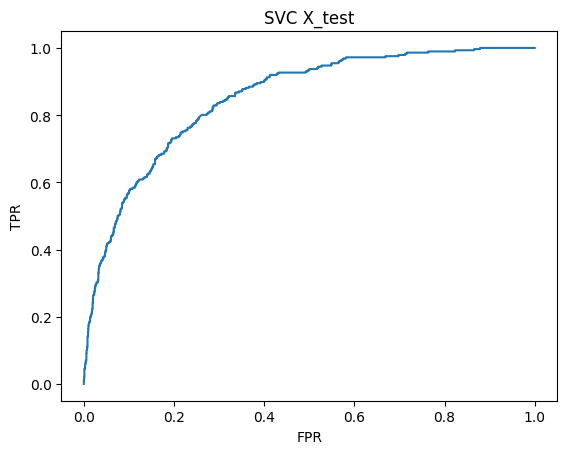

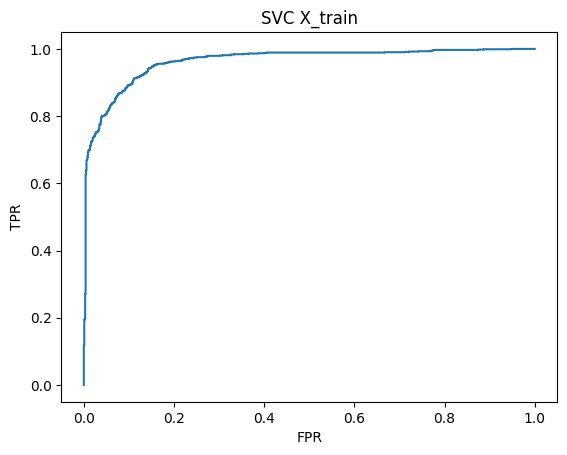

(SVC) Time to train 1.414428949356079
(SVC) Avg time to classify 0.0002079274339627211
(SVC) (X_test) accuracy, precision, recall, specificity, AUROC (0.7447118891320205, 0.2626146788990826, 0.8006993006993007, 0.7381921824104235, 0.8504290904535204)
(SVC) (X_train) accuracy, precision, recall, specificity, AUROC (0.899803536345776, 0.8913461538461539, 0.9106090373280943, 0.8889980353634578, 0.963232058699789)
(2742,) (2036,)


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_r

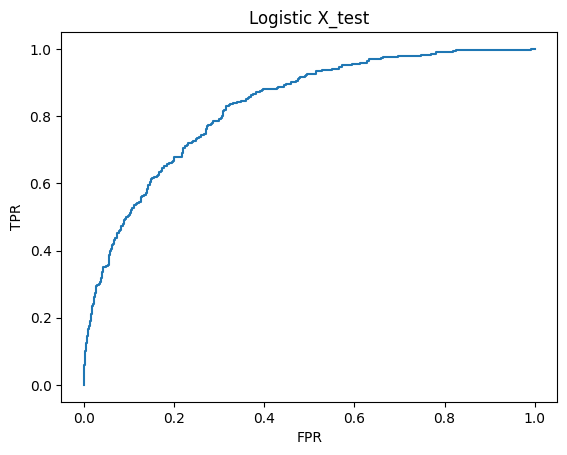

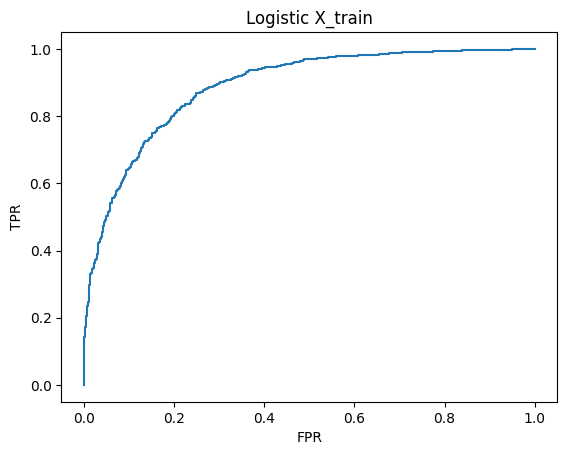

(Logistic) Time to train 0.055168867111206055
(Logistic) Avg time to classify 1.416860228468257e-06
(Logistic) (X_test) accuracy, precision, recall, specificity, AUROC (0.7396061269146609, 0.24941451990632318, 0.7447552447552448, 0.7390065146579805, 0.829686396665224)
(Logistic) (X_train) accuracy, precision, recall, specificity, AUROC (0.7996070726915521, 0.8043912175648703, 0.7917485265225933, 0.8074656188605108, 0.8879944882102508)


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:869: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel(

(2742,) (2036,)


/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/benware/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y

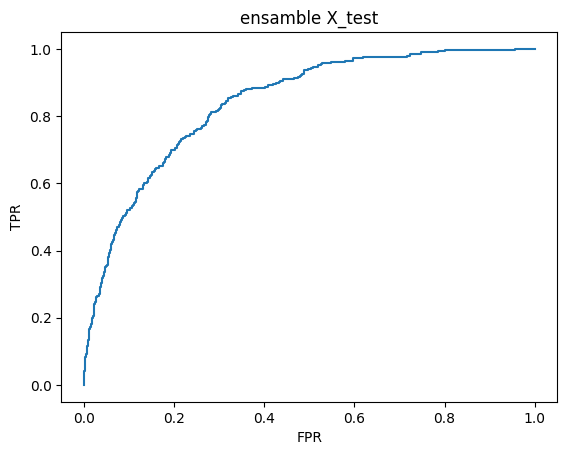

/var/folders/qd/q50f4_v16n7fp25tfl78t3ph0000gn/T/ipykernel_60144/1136690420.py:4: RuntimeWarning: invalid value encountered in long_scalars
  precision = tp / (tp+fp)


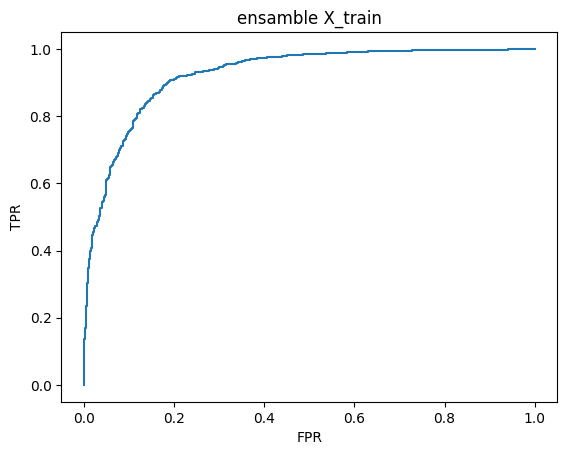

(ensamble) (X_test) accuracy, precision, recall, specificity, AUROC (0.8956965718453683, nan, 0.0, 1.0, 0.840833637046992)
(ensamble) (X_train) accuracy, precision, recall, specificity, AUROC (0.5, nan, 0.0, 1.0, 0.9247918604606281)


0.840833637046992

In [10]:
y_train, y_test = train_test(balance_train=True)

sign_train, sign_test = prep_signs_data(y_train, y_test)
rad_train, rad_test = prep_radiology_data(y_train, y_test)
demo_train, demo_test = prep_demo_data(y_train, y_test)

X_train = pd.concat([sign_train, rad_train, demo_train], axis=1)
X_test = pd.concat([sign_test, rad_test, demo_test], axis=1)

X_train.columns = X_train.columns.astype('str')
X_test.columns = X_test.columns.astype('str')


# svm
svc = svm.SVC(kernel='rbf', probability=True)
logreg = LogisticRegression()
run_tests(svc, 'SVC', X_train, y_train, X_test, y_test)
run_tests(logreg, 'Logistic', X_train, y_train, X_test, y_test)

run_tests_ensamble([svc, logreg], [sign_train, rad_train, demo_train], y_train, [sign_test, rad_test, demo_test], y_test)

## NN TIME

In [15]:
import keras_tuner
import keras


2024-04-04 21:50:24.988157: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
